# MuJoCo HAPTIX Spike Train Analysis

#### This script demonstrates how to use the MuJoCo HAPTIX simulation environment to generate fingertip sensory data and convert that data to a format compatible with spike train analysis tools.

### Dependencies:
* MATLAB installed - must also be connected to VPN for the engine to start if applicable.
    * Install the MATLAB engine API for Python. This allows user to `import matlab.engine()`
    * https://www.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html
* MuJoCo HAPTIX must be installed and running `MPL_key.xml` when the `haptix_sense()` function is called
    * MuJoCo HAPTIX Installation: https://www.roboti.us/index.html
    * MuJoCo HAPTIX Documentaiton (if interested): http://www.mujoco.org/book/haptix.html
    * Run MuJoCo HAPTIX from `mjhaptix150\mjhaptix150\program\mjhaptix.exe`
    * Open `MPL_key.xml` in HAPTIX from  `mjhaptix150\mjhaptix150\model\MPL\MPL_Key.xml`
* Relevant files from bitbucket repo:
    * `blast/mujoco_sense.py` - controls the MATLAB engine API for Python
    * `blast/matlab/HaptixInterface.mat` - Interface between MATLAB and MuJoCo HAPTIX
    * `blast/matlab/MuJoCoSense.mat` - Sensing & data collection in MuJoCo HAPTIX env
    * `blast/matlab/MuJoCoToSpikes.mat` - Converting HAPTIX data to neural response
    * `blast/matlab/MuJoCoToStruct.mat` - Preprocessing for spike train analysis 
    * `blast/TouchSimMat2Python_Loader.py` - Loads preprocessed responses to Python data types
    * `blast/spiketrainanalysis.py` - Toolkit for spike train analysis
    * `blast/trialstats.py` - Wrapper for simplified spike train analysis
    
    
#### Other Important Notes:
* If this script fails, you can try to open MATLAB and perform the data generation and processing. This may determine if your MATLAB engine API is correctly installed. 
* If you receive a license error, try again after a few moments. If the error persists, visit the link in the error message for debug. 
* At the time of development, 'ftsn' must be in the filename for the output spikes to be loaded by TouchSimMat2Python_Loader.py, if this function throws an error, check for that.
* It appears the MATLAB API for Python prefers scientific notation over direct numerical entry. So it is recommended to use `1e3` instead of `1000` as function input parameters.

#### Links that may help for development/debug:
* https://www.mathworks.com/matlabcentral/answers/216384-why-do-i-receive-license-manager-error-7
* https://www.mathworks.com/matlabcentral/answers/93627-why-do-i-receive-license-manager-error-16
* https://www.mathworks.com/help/matlab/apiref/matlab.engine.matlabengine-class.html
* https://www.mathworks.com/matlabcentral/answers/202901-problem-of-call-user-script-from-python

    
   

`mujoco_sense.py` is the main python script file containing a class object with function calls to MATLAB. Import it first. Also import `spiketrainanalysis.py` and `trialstats.py` if you intend to perform data analysis.

In [1]:
import sys; sys.path.insert(0, '..') # This line allows imports from the parent directory /blast/
import mujoco_sense as mjs
import spiketrainanalysis as sta
import trialstats as ts
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

Now you must declare where you want files to be saved or loaded from. Directories MUST be specified for any of the following actions:

* The directory with indentation depths (in mm) must be specified if calling `MuJoCoToSpikes()`. It is automatically created if `haptix_sense()` is called beforehand, however.
* The directory with neural responses must be specified if calling `MuJoCoSpikesToStruct()`. It is automatically created if `MuJoCoToSpikes()` is called beforehand, however.


In [2]:
from pathlib import Path
home = str(Path.home())

# Save path for indentation depths (in mm) from MuJoCo HAPTIX
spikes_path = fr"C:\Users\browncj1\Box\personal_BLAST\throwaway4\indentation_depths"

# Load and save path for converting indentation depths (in mm) to neural spike responses
data_path = spikes_path
save_path = fr'C:\Users\browncj1\Box\personal_BLAST\throwaway4\spikes'

# Load and save path for converting neural spike responses to analysis-compatible format
data_dir = save_path
processed_dir = fr'C:\Users\browncj1\Box\personal_BLAST\throwaway4\spikes - touchsim2struct'

Instantiate a `MujoCoSense` class object. This starts the MATLAB engine and imports paths

In [3]:
mj = mjs.MujoCoSense()

MATLAB engine starting.
Engine started.
Importing paths. This may take a few minutes.
Calling setup_path.
All paths imported.


In [4]:
# haptix_sense() will connect the MATLAB engine to an already-running 
# instance of MuJoCo (see dependencies above) and begin sensing. 
# Specify the trial_count parameter to determine the number of trials to create.
mj.eng.mj_close(nargout=0) # Close pre-exisiting connections with MuJoCo
mj.haptix_sense(spikes_path, step_count=1e3, target_sampling_frequency=1e2, trial_count=10) # use scientific notation

Calling MuJoCoSense for haptic sensing. Performing 10 trial(s).
Finished haptic sensing.
Saved to C:\Users\browncj1\Box\personal_BLAST\throwaway4\indentation_depths


In [5]:
# Once indentaiton depths are created from haptix_sense(), 
# they can be migrated to neural responses with the MuJoCoToSpikes() function.
mj.MuJoCoToSpikes(data_path, save_path)

Converting indentation depths to neural spikes.
Finished converting forces.
Saved to C:\Users\browncj1\Box\personal_BLAST\throwaway4\spikes


In [6]:
# Finally, use MuJoCoSpikesToStruct() to convert the neural responses to a struct format 
# that can be used with the trialstats.py and spiketrainanalysis.py data analysis scripts.
mj.MuJoCoSpikesToStruct(data_dir, processed_dir)

Beginning pre-processing for spike train analysis.
Finished pre-processing.
Saved to C:\Users\browncj1\Box\personal_BLAST\throwaway4\spikes - touchsim2struct


### Spike Train Analysis

In [7]:
spikes_dir = processed_dir

#  The user can specify filenames if (s)he desires a specific combination of files 
files = ['spikes_sensor_ftsn_indendation_depths_1.mat',
        'spikes_sensor_ftsn_indendation_depths_2.mat']

# dim must be None when using trial_select so that the function does not look for dim in the filename
smart_files, _ = ts.trial_select(spikes_dir, obj='key', dim=None) 

#### Comapring Afferents

loading  spikes_ftsn_object_key_sf_449_trial_1.mat
np array and metadata dictionary constructed for  spikes_ftsn_object_key_sf_449_trial_1.mat , now creating dictionary with both
loading  spikes_ftsn_object_key_sf_464_trial_2.mat
np array and metadata dictionary constructed for  spikes_ftsn_object_key_sf_464_trial_2.mat , now creating dictionary with both
loading  spikes_ftsn_object_key_sf_485_trial_10.mat
np array and metadata dictionary constructed for  spikes_ftsn_object_key_sf_485_trial_10.mat , now creating dictionary with both
loading  spikes_ftsn_object_key_sf_488_trial_3.mat
np array and metadata dictionary constructed for  spikes_ftsn_object_key_sf_488_trial_3.mat , now creating dictionary with both
loading  spikes_ftsn_object_key_sf_490_trial_9.mat
np array and metadata dictionary constructed for  spikes_ftsn_object_key_sf_490_trial_9.mat , now creating dictionary with both
loading  spikes_ftsn_object_key_sf_491_trial_8.mat
np array and metadata dictionary constructed for  sp

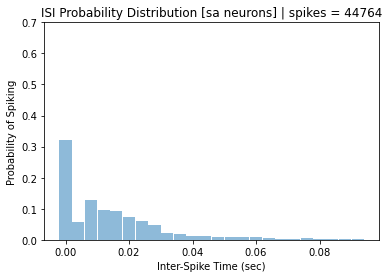

loading  spikes_ftsn_object_key_sf_449_trial_1.mat
np array and metadata dictionary constructed for  spikes_ftsn_object_key_sf_449_trial_1.mat , now creating dictionary with both
loading  spikes_ftsn_object_key_sf_464_trial_2.mat
np array and metadata dictionary constructed for  spikes_ftsn_object_key_sf_464_trial_2.mat , now creating dictionary with both
loading  spikes_ftsn_object_key_sf_485_trial_10.mat
np array and metadata dictionary constructed for  spikes_ftsn_object_key_sf_485_trial_10.mat , now creating dictionary with both
loading  spikes_ftsn_object_key_sf_488_trial_3.mat
np array and metadata dictionary constructed for  spikes_ftsn_object_key_sf_488_trial_3.mat , now creating dictionary with both
loading  spikes_ftsn_object_key_sf_490_trial_9.mat
np array and metadata dictionary constructed for  spikes_ftsn_object_key_sf_490_trial_9.mat , now creating dictionary with both
loading  spikes_ftsn_object_key_sf_491_trial_8.mat
np array and metadata dictionary constructed for  sp

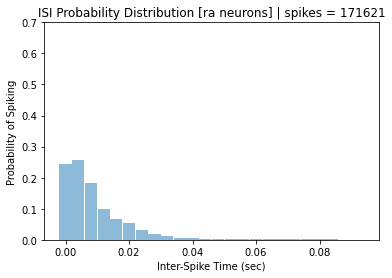

0.4804223243522739

In [8]:
bin_min = 0
bin_max = 0.1
bins = 25
bin_step = bin_max / bins
n_bins = np.arange(bin_min, bin_max, bin_step)

kl_divergence = ts.compare_afferent(data_dir=spikes_dir, 
                                    trials=smart_files, 
                                    afferent1='sa', 
                                    afferent2='ra', 
                                    n_bins=n_bins, 
                                    trq_sensor_no=0, 
                                    y_axis_limit=.7,)
kl_divergence

#### Comapring Trials


loading  spikes_ftsn_object_key_sf_496_trial_5.mat
np array and metadata dictionary constructed for  spikes_ftsn_object_key_sf_496_trial_5.mat , now creating dictionary with both


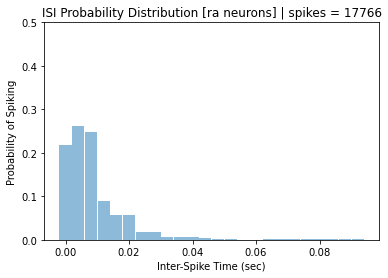

loading  spikes_ftsn_object_key_sf_464_trial_2.mat
np array and metadata dictionary constructed for  spikes_ftsn_object_key_sf_464_trial_2.mat , now creating dictionary with both


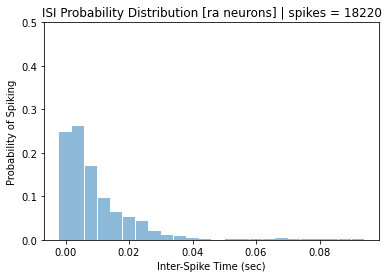

0.07310960425358451

In [9]:
trial1, _ = ts.trial_select(spikes_dir, obj='key', dim=None, trial=5)
trial2, _ = ts.trial_select(spikes_dir, obj='key', dim=None, trial=2)

kl_divergence = ts.compare_trial(data_dir=spikes_dir, 
              trial_set1=trial1, 
              trial_set2=trial2, 
              n_bins=n_bins, 
              neuron=None, 
              afferent_type='ra', 
              trq_sensor_no=0, 
              y_axis_limit=.5)

kl_divergence